In [1]:
# import required libraries for scraping
from urllib.request import urlopen, Request
!pip install bs4
from bs4 import BeautifulSoup
import pandas as pd
import os
import csv

#import required libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

Because the FINVIZ website only shows as many articles as the page can fit, we may not start out with enough articles
collected (per ticker). For use in the future, we may then want to scrape the website and then save that data as a .csv file. That means that (in the future) we can run sentiment analysis on a longer timeframe of our choosing (e.g. over one month rather than over 5 days).

In [2]:
# scrape article titles from FINVIZ
finviz_url = 'https://finviz.com/quote.ashx?t='                      # the common factor of all ticker urls
tickers = ['TSLA', 'AAPL', 'FB']

news_tables = {}                                                     # dictionary to store news data found in a table within
                                                                     # the source code

for ticker in tickers:
    url = finviz_url + ticker                                        # specify url format
    req = Request(url=url, headers={'user-agent': 'my-app'})         # verify user access
    response = urlopen(req)                                          # open the request
    
    html = BeautifulSoup(response, 'html')                           # mention html parser 
    news_table = html.find(id='news-table')                          # retrieve html object of the news table
    news_tables[ticker] = news_table                                 # store data by key 'ticker'

In [3]:
# remove file if necessary
os.remove("finvizData.csv") 

In [4]:
# create new csv file if doesn't exist
if not os.path.isfile('./finvizData.csv'):
    with open ('finvizData.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Ticker','Date','Time','News_Title'])            # specify headers


# record existing rows
seen = []
with open('finvizData.csv', 'r', encoding='windows-1252', newline='') as in_file:
    for row in in_file:
        if row in seen: continue
        
        seen.append(row)
                
print(seen)      # after change to 'data has been scraped' and put at bottom

# append data to file
with open('finvizData.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    
    for ticker, news_table in news_tables.items():                    # iterate over key, value pairs in news_tables
    
        for row in news_table.findAll('tr'):                             
        
            title = row.a.text                                        # get title of the news article by tag 'a'
            date_data = row.td.text.split(' ')                        # get date data by tag 'td' + split by 'space'
    
            if len(date_data) == 1:                                   # split the date_data to retrieve both time and date
                time = date_data[0]
            else:
                date = date_data[0]
                time = date_data[1]
            
            entry = [ticker, date, time, title]
            
            if entry in seen: continue                                # if entry exists, continue to next loop
            writer.writerow(entry)                                    # only write row if entry not in seen()
            

# 11/09/21 - only data up to 10th, so we have 301 rows

['Ticker,Date,Time,News_Title\r\n']


In [5]:
# import dependencies for sentiment analysis using the neural network I created in ./Natural_Language_Classification
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# load data from csv file into dataframe
df = pd.read_csv('finvizData.csv', encoding = 'unicode_escape')          # encoding required for unicode decode error
df

,Ticker,Date,Time,News_Title
0,TSLA,Sep-10-21,09:45PM,5 Best Chinese Stocks To Buy And Watch As Beij...
1,TSLA,Sep-10-21,09:35PM,Dow Jones Futures: Market Rally Retreats Amid ...
2,TSLA,Sep-10-21,04:46PM,Replay: Wejo CEO & VOSO CEO in Fireside Chat
3,TSLA,Sep-10-21,04:39PM,"Stock Market Rally Pulls Back; Lululemon, Affi..."
4,TSLA,Sep-10-21,04:13PM,Cathie Wood's Ark ETFs Sell $139 Million Worth...
...,...,...,...,...
295,FB,Sep-01-21,04:28PM,Facebook Stock Gets a Downgrade. Watch the Thr...
296,FB,Sep-01-21,04:18PM,"Why Facebook Stock Dropped This Morning, but A..."
297,FB,Sep-01-21,04:15PM,Elizabeth Warren Urges Justice Department to I...
298,FB,Sep-01-21,03:33PM,Facebook's Latest Move To Win User Time From T...


In [7]:
# load tokenizer
with open('./tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# load model
model = tf.keras.models.load_model('./model_1')

In [8]:
# set variables
oov_tok = '<OOV>'
padding_type = 'post'
trunc_type = 'post'
vocab_size = 1000
max_length = 142

# create function so that we can mass-preprocess the sentences (news titles)
def preprocessText(text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences,
                           maxlen=max_length,
                           padding=padding_type,
                           truncating=trunc_type)
    return padded

# preprocess entire 'News Title' column
prep = preprocessText(df['News_Title'])

In [9]:
# implement sentiment prediction on our scraped data
prep = model.predict(prep)
prep[:10]

array([[0.0653277 , 0.47739896, 0.4572733 ],
       [0.17739215, 0.34629798, 0.47630984],
       [0.07967422, 0.45266575, 0.46765998],
       [0.151807  , 0.36837715, 0.47981578],
       [0.0426607 , 0.5233756 , 0.43396375],
       [0.2709011 , 0.27324662, 0.45585227],
       [0.35602573, 0.2219635 , 0.42201075],
       [0.01554439, 0.6278971 , 0.35655853],
       [0.23303592, 0.2992329 , 0.46773112],
       [0.01171632, 0.6428368 , 0.34544683]], dtype=float32)

In [10]:
# create a new column that stores the predicted sentiment
df['Sentiment'] = np.argmax(prep, axis = -1)
df

,Ticker,Date,Time,News_Title,Sentiment
0,TSLA,Sep-10-21,09:45PM,5 Best Chinese Stocks To Buy And Watch As Beij...,1
1,TSLA,Sep-10-21,09:35PM,Dow Jones Futures: Market Rally Retreats Amid ...,2
2,TSLA,Sep-10-21,04:46PM,Replay: Wejo CEO & VOSO CEO in Fireside Chat,2
3,TSLA,Sep-10-21,04:39PM,"Stock Market Rally Pulls Back; Lululemon, Affi...",2
4,TSLA,Sep-10-21,04:13PM,Cathie Wood's Ark ETFs Sell $139 Million Worth...,1
...,...,...,...,...,...
295,FB,Sep-01-21,04:28PM,Facebook Stock Gets a Downgrade. Watch the Thr...,2
296,FB,Sep-01-21,04:18PM,"Why Facebook Stock Dropped This Morning, but A...",2
297,FB,Sep-01-21,04:15PM,Elizabeth Warren Urges Justice Department to I...,1
298,FB,Sep-01-21,03:33PM,Facebook's Latest Move To Win User Time From T...,2


#### Some examples:
(note that 0:Negative, 1:Neutral, 2:Positive)

In [14]:
df.iloc[90]

Ticker                                                     TSLA
Date                                                  Sep-05-21
Time                                                  08:06AM  
News_Title    German decision on Tesla subsidies expected by...
Sentiment                                                     2
Name: 90, dtype: object

In [16]:
df.iloc[15]

Ticker                                               TSLA
Date                                            Sep-10-21
Time                                            08:10AM  
News_Title    Why This Pricey Growth Stock Is a Smart Buy
Sentiment                                               1
Name: 12, dtype: object

In [12]:
df.iloc[210]

Ticker                                                       FB
Date                                                  Sep-10-21
Time                                                  10:35AM  
News_Title    Facebook expands Euston office in boost for Lo...
Sentiment                                                     2
Name: 210, dtype: object

In [13]:
df.iloc[170]

Ticker                                                     AAPL
Date                                                  Sep-09-21
Time                                                  02:55PM  
News_Title    Apples Watch Software Chief Takes Over Self-Dr...
Sentiment                                                     0
Name: 170, dtype: object

#### A Potential Flaw?
In the barchart below, we can see that the results are heavily skewed towards a positive sentiment. Whilst this does not inherently imply that my model has not performed well, it does concern me that the model may have some statistical bias. Some initial solutions that come to mind are the need for a larger training dataset as well as a longer timeframe for for the articles to span.

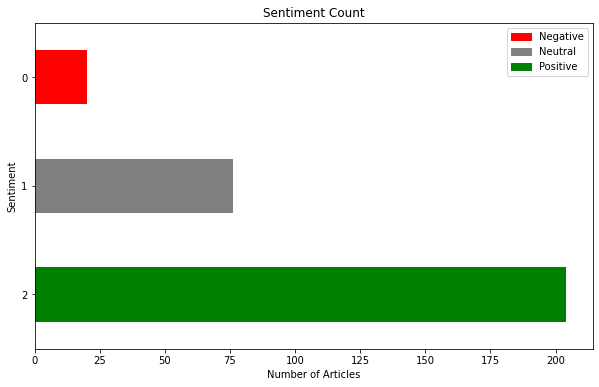

In [17]:
# create bar chart to visualise sentiment count
df['Sentiment'].value_counts().plot(kind='barh', color=['green','grey','red'])
plt.title('Sentiment Count')
plt.xlabel('Number of Articles')
plt.ylabel('Sentiment')

# creating legend 
red_patch = mpatches.Patch(color='red', label='Negative')
grey_patch = mpatches.Patch(color='grey', label='Neutral')
green_patch = mpatches.Patch(color='green', label='Positive')
plt.legend(handles=[red_patch, grey_patch, green_patch])
plt.show()

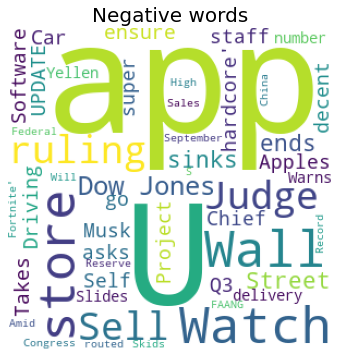

In [22]:
# function for wordcloud generation
def wordcount_cloud(df, sentiment):
    '''
    Generates word cloud
    inputs:
        - df (the scraped news headlines)
        - sentiment (positive/negative/neutral)
    '''
    # combine text by sentiment category
    comb_text = " ".join([title for title in df[df['Sentiment']==sentiment]['News_Title']])
    
    # assigning sentiment values
    if sentiment == 0:
        x = 'Negative'
    elif sentiment == 1:
        x = 'Neutral'
    else:
        x = 'Positive'
    
    # adding additional stopwords
    stop_words = ['Tesla', 'Apple', 'Facebook', 'Stock', 'Stocks'] + list(STOPWORDS)
    
    # generate and plot wordcloud
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords=stop_words,
                   height=300,
                   width=300)
    
    plt.imshow(wc.generate(comb_text))
    plt.title(f'{x} words', fontsize=20)
    plt.axis('off')
    plt.show
    
wordcount_cloud(df, 0)

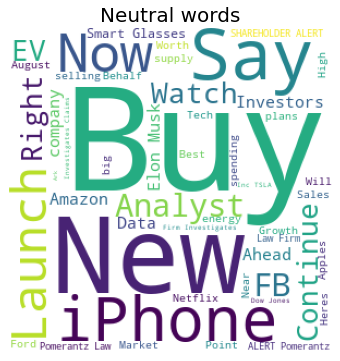

In [23]:
wordcount_cloud(df, 1)

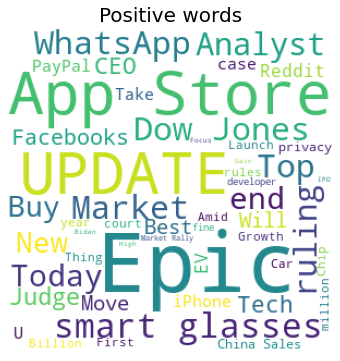

In [24]:
wordcount_cloud(df, 2)